# Supervised Machine Learning for Click Fraud Detection<br>[Main Workbook]

MLND Capstone Project<br>
Shan Dou<br>
July 2018

### Summary
This jupyter notebook (`MLNDcapstone_shandou_main.ipynb`) is the main workbook of the capstone project. The raw data files were obtained from Kaggle competion [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection). The raw training dataset has around 200 million records, but only 0.1% of the raw records are used throughout this notebook to keep the analysis lightweight. The **end-to-end workflow** is developed here, and to examine the robustness of the workflow, this data size is doubled and the corresponding results are detailed in the companion notebook `MLNDcapstone_shandou_robustness.ipynb`.

The implementation in this notebook consists of three main sections:
* Data inspection and loading:
    * Inspect data fields of the raw training and testing csv files
    * Subsample 0.1% of the records for data analysis and machine learning
    * Load data into pandas dataframe
* Exploratory data analysis and feature engineering
    * Check extent of class imbalance and cardinality of the categorical features
    * Extract hour-of-the-day information from timestamps
    * Train-test split (70% training and 30% testing)
    * Obtain rare-label imputer from training data and apply it to both training and testing data
    * Obtain category-to-number encoder from training data and apply it to both training and testing data
    * Feature correlation inspections
* Machine learning
    * Prepare features matrixes and target arrays for machine learning
    * Model evaluations:
        * Hyperparameter tuning for logistic regression and random forest
        * Compare performance of logistic regression, random forest, stack ensemble, extreme gradient boosting, and light gradient boosting
    * Model selection: Choose light gradient boosting as the most desirable model
    * Feature importance check: Check the importance rankings of all features
* Conclusion
    
----


In [1]:
# Notebook settings

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Disable jupyter notebook autoscrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Imports

import os
import subprocess
import warnings
warnings.simplefilter("ignore")
from cycler import cycler
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
linecolors = sns.color_palette('Set1')
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlens.ensemble import SuperLearner
import xgboost as xgb
import lightgbm as lgb

%reload_ext autoreload
%autoreload 2
import preprocessing
import modeling
import utils

plt.style.use('./stylelib/custom.mplstyle')

[MLENS] backend: threading


---

## 1 Data inspection and loading
### 1.1 Downsample training data
__Data size considerations__: The raw training data from kaggle has close to 200 million lines and takes 7 GB of memory. To keep EDA and evaluation steps of machine learning algorithms lightweight, a randomly sampled subset (0.1%) is used for EDA and model evaluation.

In [5]:
dir_data = './data'
from_scratch = False

# When from_scratch = True, generate randomly sampled subset
csv_train_raw = os.path.join(dir_data, 'train.csv')
csv_train = os.path.join(dir_data, 'train_sample.csv')
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_train_raw, csv_out=csv_train, fraction=0.001
    )

### 1.2 Load data into dataframe
#### (1) Field inspections
For efficiency concerns, we use shell commands instead of pandas operations.

In [6]:
# Quick check of training data fields by calling system shell command
!head -2 ./data/train_sample.csv

ip,app,device,os,channel,click_time,attributed_time,is_attributed
93766,3,1,19,205,2017-11-07 10:28:10,,0


In [7]:
# Quick check of test data fields by calling system shell command
!head -2 ./data/test.csv

click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00


**[Notes] Field selections** <br>
Field inspection tells us that training and testing data don't share the same fields. 
To prepare data for subsequent processing, we only preserve fields that are shared by both training and testing data. One exception is the `is_attributed` field in training data; It is the prediction target and thus needs to be preserved.

In [8]:
# Extract field names from training and testing data
dir_data = './data'
csv_train = os.path.join(dir_data, 'train_sample.csv')
fields_train = preprocessing.csv_list_fields(csv_in=csv_train)
csv_test = os.path.join(dir_data, 'test.csv')
fields_test = preprocessing.csv_list_fields(csv_in=csv_test)

# Extract fields shared by both training and testing data
fields_keep = list(set(fields_train) & (set(fields_test)))
print('Data fields shared by both training and testing data:\n', fields_keep)

Data fields shared by both training and testing data:
 ['app', 'device', 'click_time', 'ip', 'os', 'channel']


#### (2) Load into dataframe

In [10]:
# Load randomly sampled data subset into pandas dataframe,
# and sort by click time (and reset index)
df = pd.read_csv(
    csv_train, usecols=fields_keep + ['is_attributed'],
    parse_dates=['click_time']
).sort_values(by='click_time').reset_index(drop=True)

# Convert click time from UTC to local time
df['click_time'] = (
    pd.DatetimeIndex(df['click_time']).tz_localize('utc')
    .tz_convert('Asia/Shanghai')
)

#### (3) Feature cardinality check

In [11]:
# Check cardinality of the raw features
df_cardinality = utils.df_check_cardinality(df)
df_cardinality

,ip,app,device,os,channel,click_time,is_attributed
n_unique,96409.000000,324.000000,609.000000,218.00000,175.000000,248157.000000,2.000000
n_unique (%),5.214009,0.017523,0.032936,0.01179,0.009464,13.420871,0.000108


__IMPORTANT__: The raw features are all categorical and are of ___<span class="mark">very high cardinality</span>___. Simpler techniques such as one hot encoding is not applicable and feature engineering will require major efforts.

---
## 2. Exploratory data analysis and feature engineering
### 2.1 Examine class proportion

In [12]:
# Inspect data size
nclick_total =len(df)
percentage_pos = (df['is_attributed'].sum()) / nclick_total * 100
print('Percentage of positive target = {:.3f}%'.format(percentage_pos))

Percentage of positive target = 0.248%


**[CAUTION] Class imbalance**<br>
Given that only __<span class="mark">~0.2%</span>__ of the records has positive target values (`df['is_attributed'] == 1`), we have **an extreme case of class imbalance** at hand.

### 2.2 Convert datetime variable to usable form
Among the datetime fields such as month, day, and hour-of-the-day, we only keep hour-of-day and name it as `click_hour` for subsequent processing.

In [13]:
# 1. Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

# 2. Drop raw `click_time`
df.drop(columns=['click_time'], inplace=True)

In [14]:
df.head(3)

,ip,app,device,os,channel,is_attributed,click_hour
0,143257,3,1,15,379,0,23
1,186555,3,1,13,379,0,23
2,119289,3,1,13,379,0,23


### 2.3 Train-test split, and set aside testing data

In [15]:
# Split the original dataframe into in-sample training and testing sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Double check class ratios after train-test split
print(
    'Training data (pos%):',
    100 * df_train['is_attributed'].sum() / len(df_train)
)
print(
    'Testing data (pos%):',
    100 * df_test['is_attributed'].sum() / len(df_test)
)

Training data (pos%): 0.24962799171151626
Testing data (pos%): 0.2449919958464933


### 2.4 Inspect variable distributions of training data

In [16]:
# Count the amount of unique values
df_counts = pd.DataFrame()
df_counts['n_unique'] = df_train.nunique()
df_counts['n_unique (%)'] = 100 * df_counts['n_unique'] / len(df_train)
df_counts.T

,ip,app,device,os,channel,is_attributed,click_hour
n_unique,87459.000000,309.000000,503.000000,204.000000,174.000000,2.000000,24.000000
n_unique (%),6.757108,0.023873,0.038862,0.015761,0.013443,0.000155,0.001854


**[TAKE AWAY]**<br>
* Without exception, the total number of unique values for each of these variables is markedly smaller than the total number of clicks. This indicates that many-to-one mapping is typical between clicks and attributes such as `ip`, `app`, and `device`. This is reasonable given that a single user can generate multiple clicks.
* The categorical features at hand are of very high cardinality. Feature engineering is going to be critical in preparing the data for machine learning.

### 2.5 Apply rare label imputation and target-guided encoding to categorical features

In [17]:
feature_list = [x for x in df_train.columns if x != 'is_attributed']

# 1. Rare label imputation
df_train, df_test = preprocessing.df_rarelabel_imputer(
    df_train, df_test, cols=feature_list, thresh_percentage=0.05
)

# 2. Categorical label encoding
df_train, df_test = preprocessing.df_label2num_encoding(
    df_train, df_test, cols=feature_list
)

### 2.6 Visualize features' correlation coefficients

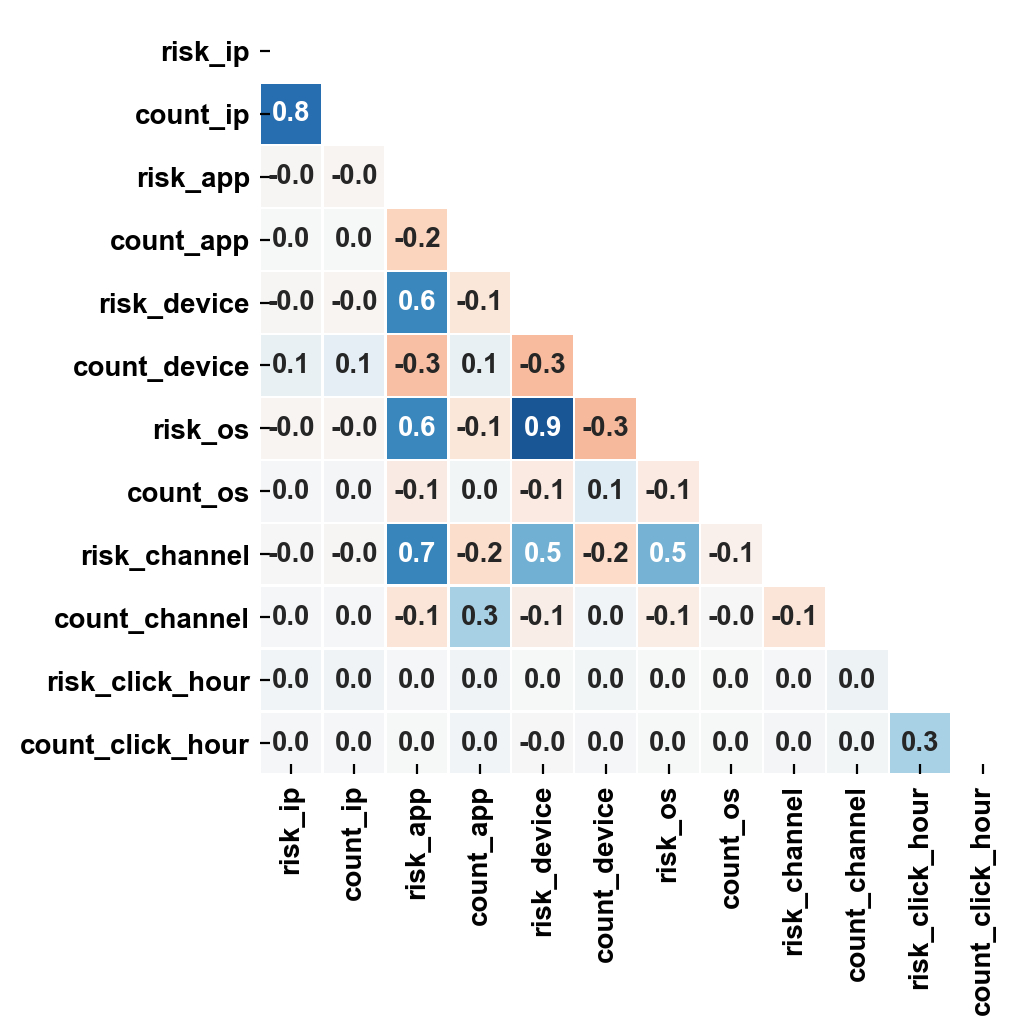

In [18]:
# Plot Pearson's correlation coefficients
utils.plot_corrmat(df_train, figsize=(5, 5))

### 2.7 Check dataframes after encoding

Note that mapping used for encoding is generated with training data and then propagated to testing data. 
Because there are non-overlap variables between training and testing data, and encoded testing data are going to have missing values. Let's have a look:

In [19]:
# Check presence of missing value after encoding
df_nulls = pd.DataFrame()
df_nulls['nan_train(%)'] = 100 * (df_train.isnull().sum() / len(df_train))
df_nulls['nan_test(%)'] = 100 * (df_test.isnull().sum() / len(df_test))
df_nulls.T

,is_attributed,risk_ip,count_ip,risk_app,count_app,risk_device,count_device,risk_os,count_os,risk_channel,count_channel,risk_click_hour,count_click_hour
nan_train(%),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.0
nan_test(%),0.0,1.869979,1.869979,0.003065,0.003065,0.020731,0.020731,0.002524,0.002524,0.00018,0.00018,0.0,0.0


---
## 3. Machine learning
### 3.1 Data preparation
Extract features matrix `X` and target array `y` for traing and testing data.

In [20]:
target_col = 'is_attributed'
feature_cols = [x for x in df_train.columns if x != target_col]
print('List of features being used:\n', feature_cols)

X_train, y_train = preprocessing.df_to_Xy(
    df_train, target_col=target_col, feature_cols=feature_cols
)
X_test, y_test = preprocessing.df_to_Xy(
    df_test, target_col=target_col, feature_cols=feature_cols
)

List of features being used:
 ['risk_ip', 'count_ip', 'risk_app', 'count_app', 'risk_device', 'count_device', 'risk_os', 'count_os', 'risk_channel', 'count_channel', 'risk_click_hour', 'count_click_hour']


In [21]:
X_train.shape

(1294326, 12)

In [22]:
y_train.shape

(1294326,)

### 3.2 Model evaluation
List of models to be evaluated:
* Logistic regression
* Random forest
* Stack ensemble
* Extreme gradient boosting
* Light gradient boosting

In [23]:
# Initialize book keeping for ROC curve, precision-recall curve,
# confusion matrixes, and feature importance ranking
model_list = ([
    'LogisticRegression', 'RandomForest', 'StackEnsemble',
    'XGBoost', 'LightGBM'
])
roc_val = dict.fromkeys(model_list)
prec_recall_val = dict.fromkeys(model_list)
confmat = dict.fromkeys(model_list)
ft_importance = dict.fromkeys(model_list)

#### (1) Benchmark: Logistic regression
1. Examine the effects of regularization `C`<br>
`C` is the inverse of the regularization strenght. The smaller `C` is, the stronger the regularization is. Here eight values varying between $1 \times 10^{-1}$ and 1 are tested. 

In [ ]:
model_name = 'LogisticRegression'

# Check effects of regularization
C_list = np.logspace(-7, 0, 8)
auc_train, auc_test = (np.zeros(C_list.size), np.zeros(C_list.size))

for i, C in enumerate(C_list):
    estimator = LogisticRegression(class_weight='balanced', C=C)
    model = modeling.Classifier(gridsearch=False)
    model.fit(estimator, X_train, y_train, cv=5)
    y_pred = model.predict(X_test)
    test_score = roc_auc_score(y_test, y_pred)

    # Score keeping
    df_scores_temp = utils.ml_performance_summary(
        model.train_score, test_score, model_name=model_name
    )
    auc_train[i] = df_scores_temp['auc_train']
    auc_test[i] = df_scores_temp['auc_test']

# Visualize model performance as a function of regularization term (C)
utils.plot_scores_vs_regparams(
    regparams=C_list, scores_train=auc_train, scores_test=auc_test,
    xlabel='C', xscale='log'
)

logisticregression
fit runtime = 28.92 s


From the graph above we can see that the best C value for logistic regression is around $1\times10^{-6}$.

2. Modeling with the best C value

In [ ]:
model_name = 'LogisticRegression'

# Use the best C value
estimator = LogisticRegression(class_weight='balanced', C=1e-6)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) 
test_score = roc_auc_score(y_test, y_pred)

# plot ROC curve
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

**[Logistic regression performance]** The noticeable difference between training and testing scores indicate overfitting, but both scores are above 0.9 and the training time is very short. The shapes of the ROC curve and precision-recall curve imply low false negative values and high false positive values.

#### (2) Bagging ensemble: Random forest
1. Check the effects of `max_depth` values

In [ ]:
model_name = 'RandomForest'

# Check effects of regularization
depth_list = np.array([1, 2, 3])
auc_train, auc_test = (np.zeros(depth_list.size), np.zeros(depth_list.size))

for i, depth in enumerate(depth_list):
    estimator = RandomForestClassifier(
        class_weight='balanced', max_depth=depth, n_estimators=50,
        random_state=42
    )
    model = modeling.Classifier(gridsearch=False)
    model.fit(estimator, X_train, y_train, cv=5)
    y_pred = model.predict(X_test)
    test_score = roc_auc_score(y_test, y_pred)

    # Score keeping
    df_scores_temp = utils.ml_performance_summary(
        model.train_score, test_score, model_name=model_name
    )
    auc_train[i] = df_scores_temp['auc_train']
    auc_test[i] = df_scores_temp['auc_test']

# Visualize model performance as a function of regularization term (C)
utils.plot_scores_vs_regparams(
    regparams=depth_list, scores_train=auc_train, scores_test=auc_test,
    xlabel='max_depth', xscale='linear'
)

From the graph above we can see that the best `max_depth` value for random forest is 1.

2. Modeling with the best `max_depth` value

In [ ]:
model_name = 'RandomForest'

# Use the best max_depth value
estimator = RandomForestClassifier(
    class_weight='balanced', max_depth=1, n_estimators=50,
    random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

**[Random forest performance]** The difference between training and testing score is smaller than that of logistic regression, which highlights the advantage of bagging ensemble in reducing overfitting. The testing score is similar to that of logistic regression, but the required training time is 4 times longer.

#### (3) Stacking ensemble: Random forest + logistic regression
Two layer stack:
* Base learners: Random forest and Naive Bayes
* Meta learner (also known as *blender*): logistic regression

In [ ]:
model_name = 'StackEnsemble'
estimator = SuperLearner(random_state=42, verbose=0)
import copy

def stacking_wrapper(estimator, proba=True):
    estimator.add([
        RandomForestClassifier(
            class_weight='balanced', max_depth=1, n_estimators=50,
            random_state=42
        ), GaussianNB()
    ], proba=proba);
    estimator.add_meta(
        LogisticRegression(class_weight='balanced'), proba=proba
    );
    
    model = modeling.Classifier(gridsearch=False)
    model.fit(estimator, X_train, y_train, cv=None)
    print(model.train_score)
    model_out = copy.deepcopy(model)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(float)
    return (y_pred, y_pred_proba, model_out)
    

# y_pred = wrapper(estimator, proba=False)
y_pred, y_pred_proba, model = stacking_wrapper(estimator, proba=True)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

# ft_importance[model_name] = utils.plot_feature_importance(
#     model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
# );

**[Stack ensemble performance]** The training and testing scores show almost no difference. The slightly better testing score should not have occurred and could have resulted from noise in the data. Note that once we increase the data size in the `aux` notebook, testing score is worse than the training data. Because of the API being used, we did not carry out cross validation in this evaluation, which explains the faster computing speed despite the inclusion of the random forest model.

#### (4) Boosting ensemble: extreme gradient boosting with tree base learner

In [ ]:
model_name = 'XGBoost'

# xgb scikit-learn API
estimator = xgb.XGBClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

**[Extreme gradient boosting performance]** Despite only using one split in the base tree learners, XGBoost shows the largest extent of overfitting. The feature importance ranking shows a markedly smaller set of useful features that those of logistic regression and random forest. Although boosting algorithm is inherently sequential, the training time of XGBoost is not much slower than parallel ensemble random forest. This reflects the superb computational efficiency of XGBoost (via efficient use of memory and parallelization of tree constructions).

#### (5) Boosting ensemble: Light gradient boosting

In [ ]:
model_name = 'LightGBM'

# lightgbm scikit-learn API
estimator = lgb.LGBMClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)


ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

**[Light gradient boosting performance]** It is interesting to see that both the performances and feature importance rankings of XGBoost and LightGBM are nearly identical, but LigthGBM is about three times faster than XGBoost.

### 3.3 Model comparison
#### (1) ROC curve

In [ ]:
# ROC curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        roc_val[model][0], roc_val[model][1], lw=3, label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1),
    xlabel='False positive rate', ylabel='True positive rate'
)
ax.legend(loc='lower right')
plt.show();

ROC curves of all the tested models have the desired shapes that indicate good performance and low false negative rates. 

#### (2) Precision-recall curve

In [ ]:
# Precision-recall curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        prec_recall_val[model][0], prec_recall_val[model][1], lw=3,
        label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1), xlabel='Recall', ylabel='Precision'
)
ax.legend(loc='upper right')
plt.show();

Because the positive class is very rare, none of the precision-recall curves have the ideal shape. The curve of LightGBM has the best shape, but its diagonal shape indicates a high false positive rate.

#### (3) Confusion matrixes

In [ ]:
# Confusion matrix comparison
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(10, 3), sharex=True, sharey=True
)
for model, axi in zip(confmat, ax.flatten()):
    cm = confmat[model].values
    labels = np.array([
        ['TN: {:d}'.format(cm[0][0]), 'FP: {:d}'.format(cm[0][1])],
        ['FN: {:d}'.format(cm[1][0]), 'TP: {:d}'.format(cm[1][1])]
    ])
    sns.heatmap(
        confmat[model], annot=labels, cmap='Blues', square=True,
        linewidths=.5, cbar=False, fmt='', ax=axi
    )
    axi.set(title=model)
plt.show();

All models show small false negative rate but high false positive rate, which explains the shapes of the ROC curves and precision-recall curves we have shown earlier.

#### (4) Feature importances

In [ ]:
# Feature importance ranking comparison
model_list_ftimportance = [x for x in model_list if x is not 'StackEnsemble']
df_ft_importance = pd.DataFrame(
    index=ft_importance[model][0], columns=model_list_ftimportance
)
for model in model_list_ftimportance:
    df_ft_importance[model] = pd.DataFrame(
        index=ft_importance[model][0],
        data=abs(ft_importance[model][1])
    )
    df_ft_importance[model] = (
        df_ft_importance[model] / np.max(abs(df_ft_importance[model]))
    )

fig, ax = plt.subplots(figsize=(4, 6))
df_ft_importance.plot(kind='barh', ax=ax, width=0.7, edgecolor='k')
ax.set(xlim=(0, 2), xlabel='Feature importance\n(normalized absolute values)')
ax.legend(loc='lower right')
plt.show();

Among all the features used in this project, both `*_ip` and `*_click_hour` features have relatively low importance values whereas `risck_channel`, `risk_app`, and `risk_os` are assigned high importances across all models. This indicates that app downloads have a closer tie to the content and nature of the mobile app, and factors such as IP and click time have almost no predicting power to app downloads.


## 4. Conclusion
---
We select light gradient boosting as the preferred model, and  results in the companion jupyter notebook that were obtained from a larger dataset also demonstrate the robustness of the selected model.